# Pipelines and Regularization

In [2]:
# import the packages we'll use
## For data handling
import pandas as pd
import numpy as np
from numpy import meshgrid

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns

## This sets the plot style
## to have a grid on a white background
sns.set_style("whitegrid")

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

## Theoretical Questions

##### 1. Deriving the Ridge Regression Estimator

Recall that finding the ridge regression coefficients involves minimizing the following:
$$
||y-X\beta||_2^2 + \alpha ||\beta||_2^2.
$$
But, this can be rewritten like so:
$$
(y-X\beta)^T(y-X\beta) + \alpha \beta^T \beta.
$$

Derive the estimate, $\hat{\beta}$ that minimizes this expression.

$$f(\beta) = y^Ty + X^T\beta^Ty - y^TX\beta - X^T\beta^TX\beta + \alpha \beta^T \beta $$

$$(y-X\beta)^T(y-X\beta) + \alpha \beta^T \beta.$$
=>

$$ y^Ty - X^T\beta^Ty - y^TX\beta + X^T\beta^TX\beta + \alpha \beta^T \beta $$
which is equivalent to 
$$ y^Ty - X^T\beta^Ty - y^TX\beta + \beta^TX^TX\beta + \alpha \beta^T \beta $$
take differiential respect to $\beta$:
using 
if $$ \alpha = x^TAx $$ then $$ \frac{\partial \alpha}{\partial x} = x^T(A + A^T) $$ 

$$ \frac{\partial f}{\partial \beta} = -y^TX -X^Ty + \beta^T(X^TX)\beta + 2\alpha\beta $$
since $$y^TX = X^Ty$$ and $$ \frac{\partial \beta^T(X^TX)\beta}{\partial \beta} = \beta^T(X^TX+X^TX) = 2\beta^TX^TX$$

$$ \frac{\partial f}{\partial \beta} = -2y^TX + 2\beta^TX^TX + 2\beta\alpha$$
let $$ \frac{\partial f}{\partial \beta} = 0 $$
$$-y^TX + \beta^TX^TX + \beta\alpha = 0$$
$$-y^TX + X^TX\beta + \alpha\beta = 0$$
gives
$$ \beta(\alpha+X^TX) = y^TX $$
then we have $$\beta = (\alpha+X^TX)^{-1}y^TX$$

### Applied

##### 1. Building your own Ridge Regression estimator.


Using your answer to the Question 1. from the Theoretical section Write code using `numpy` to find the ridge regression coefficients for the following data. Remembering to include the normalizing step using `StandardScaler`. Fit the data with a high degree polynomial.

In [3]:
x_train = 3*(np.pi/2)*np.random.random(500) - 2*np.pi
y_train = np.sin(x_train) + .3*np.random.randn(500)

x_test = 3*(np.pi/2)*np.random.random(500) - 2*np.pi
y_test = np.sin(x_test) + .3*np.random.randn(500)

In [4]:
from numpy.linalg import inv
from numpy import identity as I

In [5]:
def ridge_estimate(X,y,alpha):
    return inv(X.transpose().dot(X) + alpha*I(np.shape(X)[1])).dot(X.transpose().dot(y))

In [6]:
# get betas list
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
d = 50
"""
pipe0 = Pipeline([('poly', PolynomialFeatures(degree=d)),
                  ('scaler', StandardScaler()),
                 ('reg', LinearRegression())])
"""
poly0 = PolynomialFeatures(degree=d)
scaler0 = StandardScaler()
x_train0 = poly0.fit_transform(x_train.reshape(-1,1))
x_train0 = scaler0.fit_transform(x_train0)
betas = []*len(alphas)
for alpha in alphas:
    betas.append(ridge_estimate(x_train0, y_train, alpha))

In [7]:
print(type(betas), type(betas[0]))
print(betas[0])

<class 'list'> <class 'numpy.ndarray'>
[ 0.          0.75869102  2.44150231 -1.69335615 -0.19890327  1.53518525
 -1.85121231  1.38228892 -0.56390964 -0.23859922  0.81437082 -1.09317608
  1.09838235 -0.90035801  0.58250079 -0.22104581 -0.12438073  0.41321466
 -0.62251376  0.7437625  -0.77921817  0.73848883 -0.63564578  0.48694973
 -0.30915456  0.11830375  0.071078   -0.2464894   0.39773124 -0.5170216
  0.59899582 -0.64062731  0.64109586 -0.60162234  0.52528362 -0.41681734
  0.28242317 -0.12956557 -0.03321889  0.19650698 -0.35016565  0.48351883
 -0.58550368  0.64481552 -0.65004127  0.58978129 -0.45275959  0.22792257
  0.09547345 -0.52778552  1.07891782]


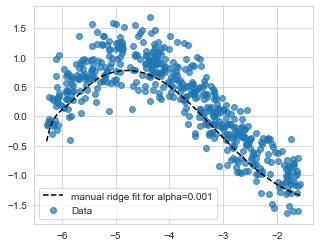

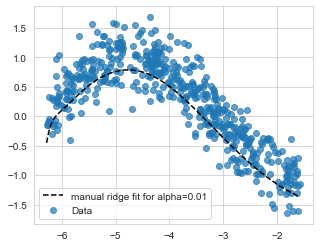

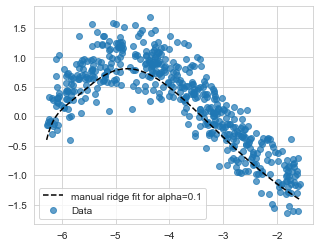

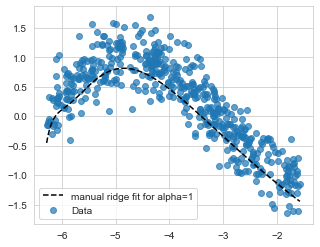

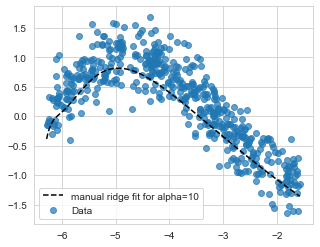

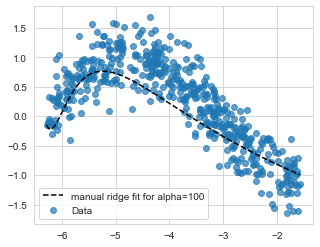

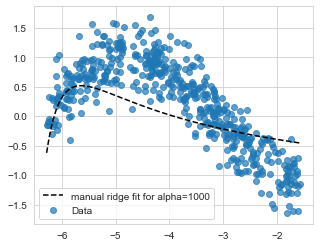

In [8]:
# plot model and data
def plot_model0(beta, alpha):
    plt.figure(figsize=(5,4))
    # x_train = 3*(np.pi/2)*np.random.random(500) - 2*np.pi
    x = 3*(np.pi/2)*np.linspace(0, 1, 500) - 2*np.pi
    x_p = poly0.transform(x.reshape(-1,1))
    x_p = scaler0.transform(x_p)
    plt.scatter(x_train, y_train, alpha=0.7, label="Data")
    plt.plot(x, x_p.dot(beta), 'k--', label = "manual ridge fit for alpha="+str(alpha))
    plt.legend(fontsize=10)
    #plt.title("")
    plt.show()
for i, beta in enumerate(betas):
    plot_model0(beta, alphas[i])

##### 2. The Elastic Net Algorithm

Elastic Net is a regularization regression algorithm that strives to set a middle ground between ridge regression and lasso. Here we set out to minimize:
$$
MSE + r\alpha ||\beta||_1 + \frac{1-r}{2}\alpha ||\beta||_2^2, \text{ for } r \in [0,1].
$$

$r$ is another hyperparameter, when $r=1$ we recover ridge regression. If $r=0$ we recover lasso.

Find the best elastic net model that includes all of the features from this `auto` data set to predict `mpg`. Learn about that data set here <a href="https://vincentarelbundock.github.io/Rdatasets/doc/ISLR/Auto.html">https://vincentarelbundock.github.io/Rdatasets/doc/ISLR/Auto.html</a>. Use cv find the best values for $r$ and $\alpha$. You can read the `ElasticNet` documentation here, <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html">https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html</a>.

In [9]:
auto = pd.read_csv("auto.csv")

auto.head()

FileNotFoundError: [Errno 2] File b'auto.csv' does not exist: b'auto.csv'

In [ ]:
from pandas.plotting import scatter_matrix

In [ ]:
scatter_matrix(auto, figsize=(14,14), alpha=0.8)
plt.show()

feature `cylinders` is categorical needs to be encoded 

In [ ]:
oneHotEnc = OneHotEncoder(sparse=False)
columnToEncode = 'cylinders'
oneHotEnc.fit(auto[[columnToEncode]])
auto_cat_one_hot = oneHotEnc.transform(auto[[columnToEncode]])
print(auto_cat_one_hot)

In [ ]:
#features = ["displacement", "horsepower", "weight","acceleration", "year"]
features = ["displacement", "weight","acceleration", "year"]
target = "mpg"
auto_train = auto.copy().sample(frac=0.75, random_state=404)
auto_test = auto.copy().drop(auto_train.index)

In [ ]:
auto_scaler = StandardScaler()
#test = np.array(auto_train[['horsepower', 'year']])
f = 'horsepower'
#auto_train[f] = auto_train[f].replace(0, '0')
auto_train[f] = auto_train[f].replace('?', '0')
auto_test[f] = auto_test[f].replace('?', '0')
test = np.array(auto_train['horsepower'])
print(test.shape)
print(test[:10])
test = auto_scaler.fit_transform(test.reshape(-1,1))

In [ ]:
print(len(auto_train))
#features = ["displacement", "horsepower", "weight","acceleration", "year"]
features = ["displacement", "weight","acceleration", "year"]
for f in features:
    if len(auto.loc[auto[f]=='?']) > 0:
        print("there is ? in ", str(f))
auto['horsepower'] = auto['horsepower'].replace('?', 0)
for f in features:
    if len(auto.loc[auto[f]=='?']) > 0:
        print("there is ? in ", str(f))

In [ ]:
auto_scaler = StandardScaler()
x_train_num = auto_scaler.fit_transform(np.array(auto_train[features]))
print("x_train_num is of shape: ", x_train_num.shape)
x_train_cat = oneHotEnc.transform(auto_train[[columnToEncode]])
print("x_train_cat is of shape: ", x_train_cat.shape)
x_train = np.concatenate([x_train_num, x_train_cat], axis=1)
print("x_train is of shape: ", x_train.shape)
y_train = np.array(auto_train[target])
print("y_train is of shape: ", y_train.shape)

In [ ]:
x_test_num = auto_scaler.fit_transform(np.array(auto_test[features]))
x_test_cat = oneHotEnc.transform(auto_test[[columnToEncode]])
x_test = np.concatenate([x_test_num, x_test_cat], axis=1)
y_test = np.array(auto_test[target])

In [ ]:
def get_mse(model, X, y):
    pred = model.predict(X)
    return np.sum(np.power(pred-y,2))/len(y)

In [ ]:
kfold = KFold(5, shuffle=True, random_state = 404)

In [ ]:
from sklearn.linear_model import ElasticNet

In [ ]:
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
#rs = np.linspace(0.01, 0.9, 100)
rs = np.linspace(0.1, 0.9, 9)
A = np.zeros((len(alphas), len(rs), 5))
k = 0 
for train_index, test_index in kfold.split(x_train, y_train):
    train_x, test_x = x_train[train_index], x_train[test_index]
    train_y, test_y = y_train[train_index], x_train[test_index]
    for i in range(len(alphas)):
        a = alphas[i]
        for j in range(len(rs)):
            r = rs[j]
            net = ElasticNet(alpha=a, l1_ratio=r)
            net.fit(train_x, train_y)
            A[i,j,k] = get_mse(net, test_x, test_y.reshape(-1,1))
    k += 1

In [ ]:
K = k
min_mse = float("inf")
min_index = []
for i in range(len(alphas)):
    for j in range(len(rs)):
        summ = sum(A[i,j,k] for k in range(K))
        temp_mse = summ/K
        if temp_mse < min_mse:
            min_mse = temp_mse
            min_index = [i, j]
print(min_index)
print("the optimal model had alpha: ", alphas[min_index[0]], "and r: ", rs[min_index[1]])

In [ ]:
min_index0 = np.unravel_index(np.argmin(np.mean(A, axis=2), axis=None),np.mean(A, axis=2).shape)
print("the optimal model had alpha: ", alphas[min_index0[0]], "and r: ", rs[min_index0[1]])
print(min_index0)

##### 3.  Beer Pipeline

Build a pipeline to fit the Beer model including the interaction between `Stout` and `ABV` from notebook 3.

Calculate the test MSE.

In [17]:
## Code here or write here
beers = pd.read_csv("beer.csv")
beers_train = beers.copy().sample(frac=0.75, random_state=404)
beers_test = beers.copy().drop(beers_train.index)
beers.head()

,Beer_Name,IBU,ABV,Rating,Beer_Type
0,Guinness Draught,45,4.2,3.792,Stout
1,Breakfast Stout,60,8.3,4.145,Stout
2,Milk Stout Nitro,25,6.0,3.951,Stout
3,Dragon’s Milk,31,11.0,4.062,Stout
4,Old Rasputin,75,9.0,4.018,Stout


In [16]:
beers['Beer_Type'].value_counts()

IPA      195
Stout    152
Name: Beer_Type, dtype: int64

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression

In [31]:
"""
def get_stout(df):
    new_df = pd.DataFrame(pd.get_dummies(df['Beer_Type']))['Stout']
    new_df['ABV'] = df['ABV']
    return new_df
"""
def get_stout(df):
    new_df =  pd.DataFrame(pd.get_dummies(df['Beer_Type'])['Stout'])
    new_df['ABV'] = df['ABV']
    return new_df

def get_mse(model, X, y):
    pred = model.predict(X)
    return np.sum(np.power(pred-y, 2))/len(X)

In [32]:
funcTrans = FunctionTransformer(get_stout, validate=False)
test_df = funcTrans.transform(beers_train[['Beer_Type', 'ABV']])
test_df.head()

,Stout,ABV
300,0,9.5
195,0,7.0
283,0,6.5
299,0,12.0
240,0,10.0


In [33]:
"""
pipe = Pipeline([('function'),FunctionTransformer(get_stout),
                 ('poly', PolynomialFeatures(degree=2, interaction_only=True)),
                 ('reg', LinearRegression())])
"""
pipe = Pipeline([('function',FunctionTransformer(get_stout, validate=False)),
                    ('poly',PolynomialFeatures(degree=2, interaction_only=True)),
                    ('reg',LinearRegression())])

pipe.fit(beers_train[['Beer_Type', 'ABV']], beers_train['IBU'])

print("The training mse is",np.round(get_mse(pipe,beers_train[['Beer_Type','ABV']],beers_train['IBU']),4))
print("The test mse is",np.round(get_mse(pipe,beers_test[['Beer_Type','ABV']],beers_test['IBU']),4))

The training mse is 326.2474
The test mse is 201.2397


##### 4. carseats Pipeline

Build a pipeline for the carseats model of your choice.

In [ ]:
## Code here or write here

##### 5. Feature selection for Advertising

Return to the best model we settled on for the Advertising data set in notebook 4. Using Ridge or Lasso Regression for feature selection in this model.

In [34]:
ads = pd.read_csv("Advertising.csv")
ads_train = ads.copy().sample(frac=0.75, random_state=440)
ads_test = ads.copy().drop(ads_train.index)

In [40]:
ads_train['sqrt_TV'] = np.sqrt(ads_train['TV'])
ads_train['sqrtTV_radio'] = ads_train['sqrt_TV']*ads_train['radio']
ads_train.head()

,TV,radio,newspaper,sales,sqrt_TV,sqrt_radio,sqrtTV_radio
90,134.3,4.9,9.3,11.2,11.588788,2.213594,56.785060
41,177.0,33.4,38.7,17.1,13.304135,5.779273,444.358099
149,44.7,25.8,20.6,10.1,6.685806,5.079370,172.493791
78,5.4,29.9,9.4,5.3,2.323790,5.468089,69.481321
148,38.0,40.3,11.9,10.9,6.164414,6.348228,248.425884


In [41]:
from sklearn.linear_model import Lasso

In [42]:
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
features = ["TV", "radio", "newspaper", "sqrt_TV", 'sqrtTV_radio']
lasso_coefs = np.empty((len(alpha), len(features)))
for i in range(len(alpha)):
    lasso = Lasso(alpha=alpha[i])
    lasso.fit(ads_train[features], ads_train['sales'])
    lasso_coefs[i,:] = lasso.coef_

In [44]:
pd.DataFrame(np.round(lasso_coefs,8), columns = features, index = ["alpha="+str(a) for a in alpha])

,TV,radio,newspaper,sqrt_TV,sqrtTV_radio
alpha=1e-05,-0.006715,-0.046408,0.002627,0.579077,0.021223
alpha=0.0001,-0.006708,-0.046414,0.002627,0.578913,0.021223
alpha=0.001,-0.006636,-0.046477,0.002627,0.577282,0.021228
alpha=0.01,-0.005912,-0.047105,0.002624,0.561002,0.021277
alpha=0.1,0.000488,-0.052981,0.002571,0.415376,0.021741
alpha=1,0.020590,-0.047963,0.000000,0.000000,0.021427
alpha=10,0.023665,-0.000000,-0.000000,0.000000,0.017701
alpha=100,0.009812,-0.000000,-0.000000,0.000000,0.018814
alpha=1000,0.000000,0.000000,0.000000,0.000000,0.000000
